**Created by Sanskar Hasija**

**😡🤢😱😊😐😔😲 Emotion Detection**

**28 OCTOBER 2021**


# <center> 😡🤢😱😊😐😔😲 EMOTION DETECTION </center>
## <center>If you find this notebook useful, support with an upvote👍</center>

## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet169 Model](#model)  ##
## [5. Training and Fine Tuning](#train) ##
## [6. Visualizing Results](#vis) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = "../input/emotion-detection-fer/train"
test_dir = "../input/emotion-detection-fer/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Images with different emotions

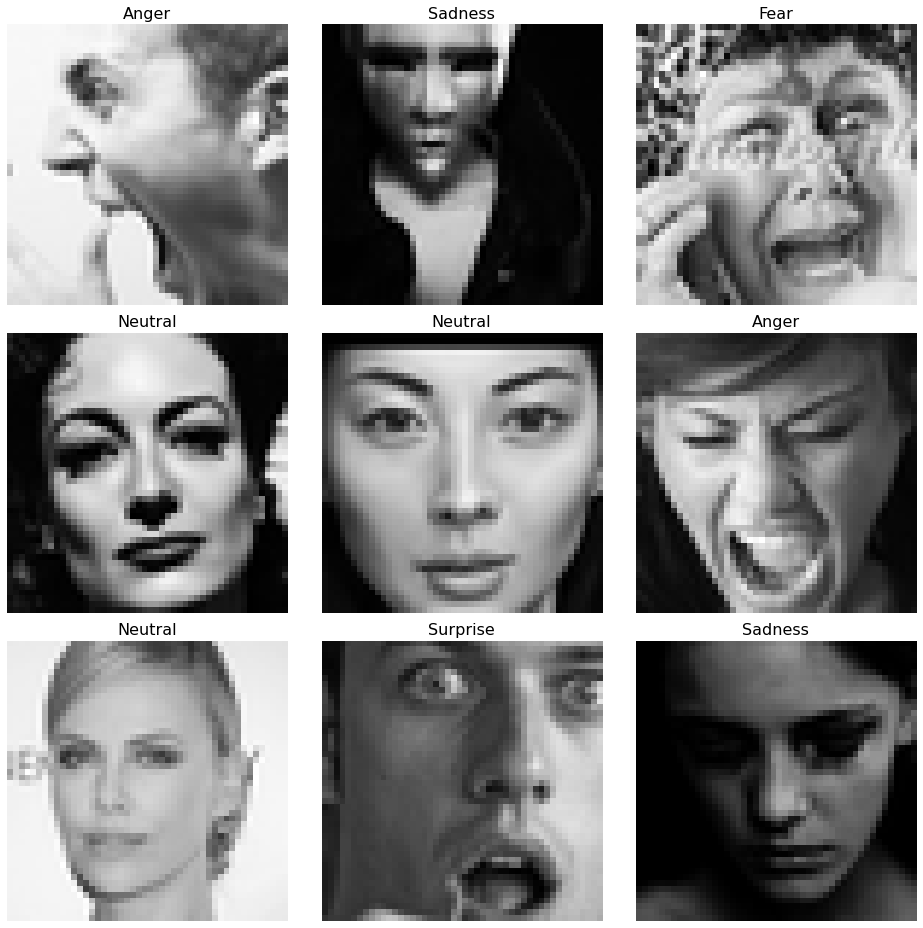

In [4]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [5]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [6]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [7]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [8]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

2021-10-28 17:34:17.364249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-28 17:34:30.376837: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


359/359 [==============================] - 140s 336ms/step - loss: 9.9331 - accuracy: 0.2891 - val_loss: 5.5342 - val_accuracy: 0.2750
Epoch 2/30
359/359 [==============================] - 56s 157ms/step - loss: 3.4128 - accuracy: 0.4223 - val_loss: 2.4288 - val_accuracy: 0.3790
Epoch 3/30
359/359 [==============================] - 57s 159ms/step - loss: 1.8440 - accuracy: 0.4688 - val_loss: 1.6175 - val_accuracy: 0.4595
Epoch 4/30
359/359 [==============================] - 57s 157ms/step - loss: 1.4522 - accuracy: 0.5016 - val_loss: 1.4011 - val_accuracy: 0.5201
Epoch 5/30
359/359 [==============================] - 56s 155ms/step - loss: 1.3111 - accuracy: 0.5324 - val_loss: 1.2429 - val_accuracy: 0.5543
Epoch 6/30
359/359 [==============================] - 57s 158ms/step - loss: 1.2460 - accuracy: 0.5520 - val_loss: 1.2713 - val_accuracy: 0.5471
Epoch 7/30
359/359 [==============================] - 56s 157ms/step - loss: 1.2122 - accuracy: 0.5662 - val_loss: 1.2596 - val_accuracy: 0.

## Fine Tuning

In [9]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
359/359 [==============================] - 70s 164ms/step - loss: 0.9970 - accuracy: 0.6693 - val_loss: 1.0773 - val_accuracy: 0.6360
Epoch 2/20
359/359 [==============================] - 58s 162ms/step - loss: 0.9609 - accuracy: 0.6813 - val_loss: 1.0681 - val_accuracy: 0.6382
Epoch 3/20
359/359 [==============================] - 58s 162ms/step - loss: 0.9503 - accuracy: 0.6806 - val_loss: 1.0651 - val_accuracy: 0.6368
Epoch 4/20
359/359 [==============================] - 57s 159ms/step - loss: 0.9348 - accuracy: 0.6883 - val_loss: 1.0626 - val_accuracy: 0.6393
Epoch 5/20
359/359 [==============================] - 58s 161ms/step - loss: 0.9310 - accuracy: 0.6900 - val_loss: 1.0603 - val_accuracy: 0.6408
Epoch 6/20
359/359 [==============================] - 58s 161ms/step - loss: 0.9139 - accuracy: 0.6989 - val_loss: 1.0607 - val_accuracy: 0.6419
Epoch 7/20
359/359 [==============================] - 57s 159ms/step - loss: 0.9176 - accuracy: 0.6957 - val_loss: 1.0582 - val_ac

## Training plots

In [10]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [11]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [12]:
model.evaluate(test_generator , verbose = 0)

[1.0665851831436157, 0.6398718357086182]

In [13]:
probs = model.predict(test_generator)
y_test =test_generator.classes
y_preds = probs >0.5
y_preds =np.argmax(y_preds, axis=1)
print(classification_report(y_test , y_preds))

              precision    recall  f1-score   support

           0       0.13      0.33      0.19       958
           1       0.00      0.00      0.00       111
           2       0.14      0.07      0.09      1024
           3       0.25      0.23      0.24      1774
           4       0.16      0.14      0.15      1233
           5       0.15      0.10      0.12      1247
           6       0.12      0.10      0.11       831

    accuracy                           0.16      7178
   macro avg       0.13      0.14      0.13      7178
weighted avg       0.17      0.16      0.16      7178

